<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D1_RealNeurons/W3D1_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 1, Tutorial 2
# Real Neurons: Effects of Input Correlation
__Content creators:__ Qinglong Gu, Songtin Li, John Murray, Richard Naud, Arvind Kumar

__Content reviewers:__ Maryam Vaziri-Pashkam, Ella Batty, Lorenzo Fontolan, Richard Gao, Matthew Krause, Spiros Chavlis, Michael Waskom

---
# Tutorial Objectives
In this tutorial, we will use the leaky integrate-and-fire (LIF) neuron model (see Tutorial 1) to study how they transform input correlations to output properties (transfer of correlations). In particular, we are going to write a few lines of code to:

- inject correlated GWN in a pair of neurons

- measure correlations between the spiking activity of the two neurons

- study how the transfer of correlation depends on the statistics of the input, i.e. mean and standard deviation.

---
# Setup

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

In [3]:
# @title Helper functions
def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['V_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400. # Total duration of simulation [ms]
  pars['dt'] = .1  # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized
                                                         # time points [ms]
  return pars


def run_LIF(pars, Iinj):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value or an array

  Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, V_L = pars['V_init'], pars['V_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  tr = 0.

  # simulate the LIF dynamics
  rec_spikes = []   # record spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (-(v[it] - V_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


def my_GWN(pars, sig, myseed=False):
  """
  Function that calculates Gaussian white noise inputs

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed. You can fix the seed of the random number generator so
  # that the results are reliable however, when you want to generate multiple
  # realization make sure that you change the seed for each new realization
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_GWN = sig * np.random.randn(Lt) * np.sqrt(pars['tau_m'] / dt)

  return I_GWN


def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

def example_plot_myCC():
  pars = default_pars(T=50000, dt=.1)

  c = np.arange(10) * 0.1
  r12 = np.zeros(10)
  for i in range(10):
    I1gL, I2gL = correlate_input(pars, mu=20.0, sig=7.5, c=c[i])
    r12[i] = my_CC(I1gL, I2gL)

  plt.figure()
  plt.plot(c, r12, 'bo', alpha=0.7, label='Simulation', zorder=2)
  plt.plot([-0.05, 0.95], [-0.05, 0.95], 'k--', label='y=x',
           dashes=(2, 2), zorder=1)
  plt.xlabel('True CC')
  plt.ylabel('Sample CC')
  plt.legend(loc='best')
  
def LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20):
  """ Simulates two LIF neurons with correlated input and computes output correlation
  
  Args:
  pars       : parameter dictionary
  mu         : noise baseline (mean)
  sig        : noise amplitute (standard deviation)
  c          : correlation coefficient ~[0, 1]
  bin_size   : bin size used for time series
  n_trials   : total simulation trials

  Returns:
  r          : output corr. coe.
  sp_rate    : spike rate
  sp1        : spike times of neuron 1 in the last trial
  sp2        : spike times of neuron 2 in the last trial
  """

  r12 = np.zeros(n_trials)
  sp_rate = np.zeros(n_trials)
  for i_trial in range(n_trials):
    I1gL, I2gL = correlate_input(pars, mu, sig, c)
    _, sp1 = run_LIF(pars, pars['g_L'] * I1gL)
    _, sp2 = run_LIF(pars, pars['g_L'] * I2gL)

    my_bin = np.arange(0, pars['T'], bin_size)

    sp1_count, _ = np.histogram(sp1, bins=my_bin)
    sp2_count, _ = np.histogram(sp2, bins=my_bin)

    r12[i_trial] = my_CC(sp1_count[::20], sp2_count[::20])
    sp_rate[i_trial] = len(sp1) / pars['T'] * 1000.

  return r12.mean(), sp_rate.mean(), sp1, sp2


def plot_c_r_LIF(c, r, mycolor, mylabel):
  z = np.polyfit(c, r, deg=1)
  c_range = np.array([c.min() - 0.05, c.max() + 0.05])
  plt.plot(c, r, 'o', color=mycolor, alpha=0.7, label=mylabel, zorder=2)
  plt.plot(c_range, z[0] * c_range + z[1], color=mycolor, zorder=1)



The helper function contains the:

- Parameter dictionary: `default_pars( **kwargs)`
- LIF simulator: `run_LIF`
- Gaussian white noise generator: `my_GWN(pars, sig, myseed=False)`
- Poisson type spike train generator: `Poisson_generator(pars, rate, n, myseed=False)`
- Two LIF neurons with correlated inputs simulator: `LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20)`
- Some additional plotting utilities

---
# Section 1: Correlations (Synchrony)
Correlation or synchrony in neuronal activity can be described for any readout of brain activity. Here, we are concerned with the spiking activity of neurons. 

In the simplest way, correlation/synchrony refers to coincident spiking of neurons, i.e., when two neurons spike together, they are firing in **synchrony** or are **correlated**. Neurons can be synchronous in their instantaneous activity, i.e., they spike together with some probability. However, it is also possible that spiking of a neuron at time $t$ is correlated with the spikes of another neuron with a delay (time-delayed synchrony). 

## Origin of synchronous neuronal activity:
- Common inputs, i.e., two neurons are receiving input from the same sources. The degree of correlation of the shared inputs is proportional to their output correlation.
- Pooling from the same sources. Neurons do not share the same input neurons but are receiving inputs from neurons which themselves are correlated.
- Neurons are connected to each other (uni- or bi-directionally): This will only give rise to time-delayed synchrony. Neurons could also be connected via gap-junctions.
- Neurons have similar parameters and initial conditions.

## Implications of synchrony
When neurons spike together, they can have a stronger impact on downstream neurons. Synapses in the brain are sensitive to the temporal correlations (i.e., delay) between pre- and postsynaptic activity, and this, in turn, can lead to the formation of functional neuronal networks - the basis of unsupervised learning (we will study some of these concepts in a forthcoming tutorial).

Synchrony implies a reduction in the dimensionality of the system. In addition, correlations, in many cases, can impair the decoding of neuronal activity.

Video available at https://youtube.com/watch?v=nsAYFBcAkes


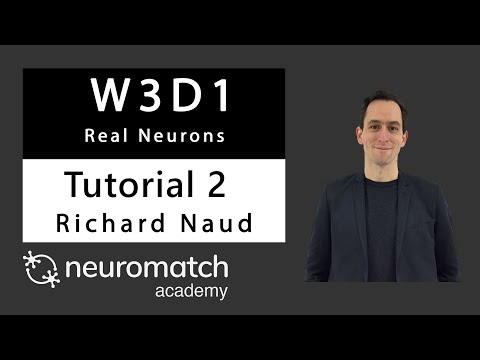

In [4]:
# @title Video 1: Input & output correlations
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="nsAYFBcAkes", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## How to study the emergence of correlations


A simple model to study the emergence of correlations is to inject common inputs to a pair of neurons and measure the output correlation as a function of the fraction of common inputs. 

Here, we are going to investigate the transfer of correlations by computing the correlation coefficient of spike trains recorded from two unconnected LIF neurons, which received correlated inputs.


The input current to LIF neuron $i$ $(i=1,2)$ is:

\begin{equation}
\frac{I_i}{g_L} =\mu_i + \sigma_i (\sqrt{1-c}\xi_i + \sqrt{c}\xi_c) \quad (1)
\end{equation}

where $\mu_i$ is the temporal average of the current. The Gaussian white noise $\xi_i$ is independent for each neuron, while $\xi_c$ is common to all neurons. The variable $c$ ($0\le c\le1$) controls the fraction of common and independent inputs. $\sigma_i$ shows the variance of the total input.

So, first, we will generate correlated inputs.

In [5]:
# @title 
#@markdown Execute this cell to get a function for generating correlated GWN inputs
def correlate_input(pars, mu=20., sig=7.5, c=0.3):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    c.         : correlation coefficient ~[0, 1]

  Returns:
    I1gL, I2gL : two correlated inputs with corr. coe. c
  """

  # generate Gaussian whute noise xi_1, xi_2, xi_c
  xi_1 = my_GWN(pars, sig)
  xi_2 = my_GWN(pars, sig)
  xi_c = my_GWN(pars, sig)

  # Generate two correlated inputs by Equation. (1)
  I1gL = mu + np.sqrt(1. - c) * xi_1 + np.sqrt(c) * xi_c
  I2gL = mu + np.sqrt(1. - c) * xi_2 + np.sqrt(c) * xi_c

  return I1gL, I2gL

print(help(correlate_input))

Help on function correlate_input in module __main__:

correlate_input(pars, mu=20.0, sig=7.5, c=0.3)
    Args:
      pars       : parameter dictionary
      mu         : noise baseline (mean)
      sig        : noise amplitute (standard deviation)
      c.         : correlation coefficient ~[0, 1]
    
    Returns:
      I1gL, I2gL : two correlated inputs with corr. coe. c

None


### Exercise 1: Compute the correlation

The _sample correlation coefficient_ between two input currents $I_i$ and $I_j$ is defined as the sample covariance of $I_i$ and $I_j$ divided by the square root of the sample variance of $I_i$ multiplied with the square root of the sample variance of $I_j$. In equation form:  

\begin{align}
r_{ij} &= \frac{cov(I_i, I_j)}{\sqrt{var(I_i)} \sqrt{var(I_j)}}\\
cov(I_i, I_j) &= \sum_{k=1}^L (I_i^k -\bar{I}_i)(I_j^k -\bar{I}_j) \\
var(I_i) &= \sum_{k=1}^L (I_i^k -\bar{I}_i)^2
\end{align}

where $\bar{I}_i$ is the sample mean, k is the time bin, and L is the length of $I$.  This means that $I_i^k$ is current i at time $k\cdot dt$. Note that the equations above are not accurate for sample covariances and variances as they should be additionally divided by L-1 - we have dropped this term because it cancels out in the sample correlation coefficient formula.

The _sample correlation coefficient_ may also be referred to as the _sample Pearson correlation coefficient_. Here, is a beautiful paper that explains multiple ways to calculate and understand correlations [Rodgers and Nicewander 1988](https://www.stat.berkeley.edu/~rabbee/correlation.pdf).

In this exercise, we will create a function, `my_CC` to compute the sample correlation coefficient between two time series. Note that while we introduced this computation here in the context of input currents, the sample correlation coefficient is used to compute the correlation between any two time series - we will use it later on binned spike trains.

In [6]:
def my_CC(i, j):
  """
  Args:
    i, j  : two time series with the same length

  Returns:
    rij   : correlation coefficient
  """
  ########################################################################
  ## TODO for students: compute rxy, then remove the NotImplementedError #
  # Tip1: array([a1, a2, a3])*array([b1, b2, b3]) = array([a1*b1, a2*b2, a3*b3])
  # Tip2: np.sum(array([a1, a2, a3])) = a1+a2+a3
  # Tip3: square root, np.sqrt()
  # Fill out function and remove
  raise NotImplementedError("Student exercise: compute the sample correlation coefficient")
  ########################################################################
  # Calculate the covariance of i and j
  cov = ...
  # Calculate the variance of i
  var_i = ...
  # Calculate the variance of j
  var_j = ...
  # Calculate the correlation coefficient
  rij = ...

  return rij


# Uncomment the line after completing the my_CC function
# example_plot_myCC()

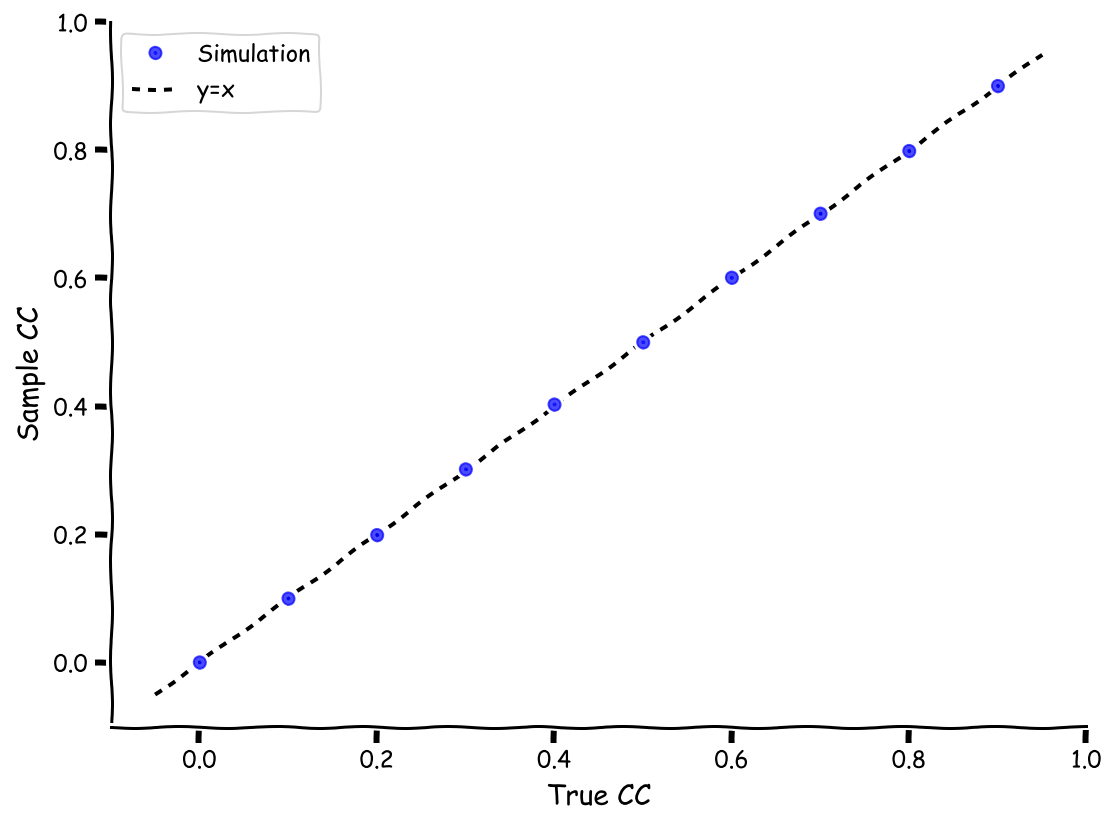

In [7]:
# to_remove solution
def my_CC(i, j):
  """
  Args:
    i, j  : two time series with the same length

  Returns:
    rij   : correlation coefficient
  """

  # Calculate the covariance of i and j
  cov = ((i - i.mean()) * (j - j.mean())).sum()
  # Calculate the variance of i
  var_i = ((i - i.mean()) * (i - i.mean())).sum()
  # Calculate the variance of j
  var_j = ((j - j.mean()) * (j - j.mean())).sum()
  # Calculate the correlation coefficient
  rij = cov / np.sqrt(var_i*var_j)

  return rij


with plt.xkcd():
  example_plot_myCC()

### Exercise 2: Measure the correlation between spike trains

After recording the spike times of the two neurons, how can we estimate their correlation coefficient? 

In order to find this, we need to bin the spike times and obtain two time series. Each data point in the time series is the number of spikes in the corresponding time bin. You can use `np.histogram()` to bin the spike times.

Complete the code below to bin the spike times and calculate the correlation coefficient for two Poisson spike trains. Note that `c` here is the ground-truth correlation coefficient that we define.

In [8]:
# @title

# @markdown Execute this cell to get a function for generating correlated Poisson inputs (generate_corr_Poisson)


def generate_corr_Poisson(pars, poi_rate, c, myseed=False):
  """
  function to generate correlated Poisson type spike trains
  Args:
    pars       : parameter dictionary
    poi_rate   : rate of the Poisson train
    c.         : correlation coefficient ~[0, 1]

  Returns:
    sp1, sp2   : two correlated spike time trains with corr. coe. c
  """

  range_t = pars['range_t']

  mother_rate = poi_rate / c
  mother_spike_train = Poisson_generator(pars, rate=mother_rate,
                                         n=1, myseed=myseed)[0]
  sp_mother = range_t[mother_spike_train > 0]

  L_sp_mother = len(sp_mother)
  sp_mother_id = np.arange(L_sp_mother)
  L_sp_corr = int(L_sp_mother * c)

  np.random.shuffle(sp_mother_id)
  sp1 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  np.random.shuffle(sp_mother_id)
  sp2 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  return sp1, sp2


print(help(generate_corr_Poisson))

Help on function generate_corr_Poisson in module __main__:

generate_corr_Poisson(pars, poi_rate, c, myseed=False)
    function to generate correlated Poisson type spike trains
    Args:
      pars       : parameter dictionary
      poi_rate   : rate of the Poisson train
      c.         : correlation coefficient ~[0, 1]
    
    Returns:
      sp1, sp2   : two correlated spike time trains with corr. coe. c

None


In [9]:
def corr_coeff_pairs(pars, rate, c, trials, bins):
  """
  Calculate the correlation coefficient of two spike trains, for different
  realizations

  Args:
      pars   : parameter dictionary
      rate   : rate of poisson inputs
      c      : correlation coefficient ~ [0, 1]
      trials  : number of realizations
      bins   : vector with bins for time discretization

  Returns:
    r12      : correlation coefficient of a pair of inputs
  """

  r12 = np.zeros(n_trials)

  for i in range(n_trials):
    ##############################################################
    ## TODO for students: Use np.histogram to bin the spike time #
    ##   e.g., sp1_count, _= np.histogram(...)
    # Use my_CC() compute corr coe, compare with c
    # Note that you can run multiple realizations and compute their r_12(diff_trials)
    # with the defined function above. The average r_12 over trials can get close to c.
    # Note: change seed to generate different input per trial
    # Fill out function and remove
    raise NotImplementedError("Student exercise: compute the correlation coefficient")
    ##############################################################

    # Generate correlated Poisson inputs
    sp1, sp2 = generate_corr_Poisson(pars, ..., ..., myseed=2020+i)

    # Bin the spike times of the first input
    sp1_count, _ = np.histogram(..., bins=...)

    # Bin the spike times of the second input
    sp2_count, _ = np.histogram(..., bins=...)

    # Calculate the correlation coefficient
    r12[i] = my_CC(..., ...)

  return r12


poi_rate = 20.
c = 0.2  # set true correlation
pars = default_pars(T=10000)

# bin the spike time
bin_size = 20  # [ms]
my_bin = np.arange(0, pars['T'], bin_size)
n_trials = 100  # 100 realizations

# Uncomment to test your function
# r12 = corr_coeff_pairs(pars, rate=poi_rate, c=c, trials=n_trials, bins=my_bin)
# print(f'True corr coe = {c:.3f}')
# print(f'Simu corr coe = {r12.mean():.3f}')

Sample output

```
True corr coe = 0.200
Simu corr coe = 0.197
```

In [10]:
# to_remove solution
def corr_coeff_pairs(pars, rate, c, trials, bins):
  """
  Calculate the correlation coefficient of two spike trains, for different
  realizations

  Args:
      pars   : parameter dictionary
      rate   : rate of poisson inputs
      c      : correlation coefficient ~ [0, 1]
      trials  : number of realizations
      bins   : vector with bins for time discretization

  Returns:
    r12      : correlation coefficient of a pair of inputs
  """

  r12 = np.zeros(n_trials)

  for i in range(n_trials):
    # Generate correlated Poisson inputs
    sp1, sp2 = generate_corr_Poisson(pars, poi_rate, c, myseed=2020+i)

    # Bin the spike times of the first input
    sp1_count, _ = np.histogram(sp1, bins=bins)

    # Bin the spike times of the second input
    sp2_count, _ = np.histogram(sp2, bins=bins)
    
    # Calculate the correlation coefficient
    r12[i] = my_CC(sp1_count, sp2_count)

  return r12


poi_rate = 20.
c = 0.2  # set true correlation
pars = default_pars(T=10000)
# bin the spike time
bin_size = 20  # [ms]
my_bin = np.arange(0, pars['T'], bin_size)
n_trials = 100  # 100 realizations

r12 = corr_coeff_pairs(pars, rate=poi_rate, c=c, trials=n_trials, bins=my_bin)
print(f'True corr coe = {c:.3f}')
print(f'Simu corr coe = {r12.mean():.3f}')

True corr coe = 0.200
Simu corr coe = 0.197


---
# Section 2: Investigate the effect of input correlation on the output correlation

Now let's combine the aforementioned two procedures. We first generate the correlated inputs by Equation (1). Then we inject the correlated inputs $I_1, I_2$ into a pair of neurons and record their output spike times. We continue measuring the correlation between the output and 
investigate the relationship between the input correlation and the output correlation.

## Drive a neuron with correlated inputs and visualize its output
In the following, you will inject correlated GWN in two neurons. You need to define the mean (`gwn_mean`), standard deviation (`gwn_std`), and input correlations (`c_in`).

We will simulate $10$ trials to get a better estimate of the output correlation. Change the values in the following cell for the above variables (and then run the next cell) to explore how they impact the output correlation.

In [11]:
# Play around with these parameters

pars = default_pars(T=80000, dt=1.)  # get the parameters
c_in = 0.3  # set input correlation value
gwn_mean = 10.
gwn_std = 10.


Simulation time = 0.05 min
Input correlation = 0.3
Output correlation = 0.07493360325177058


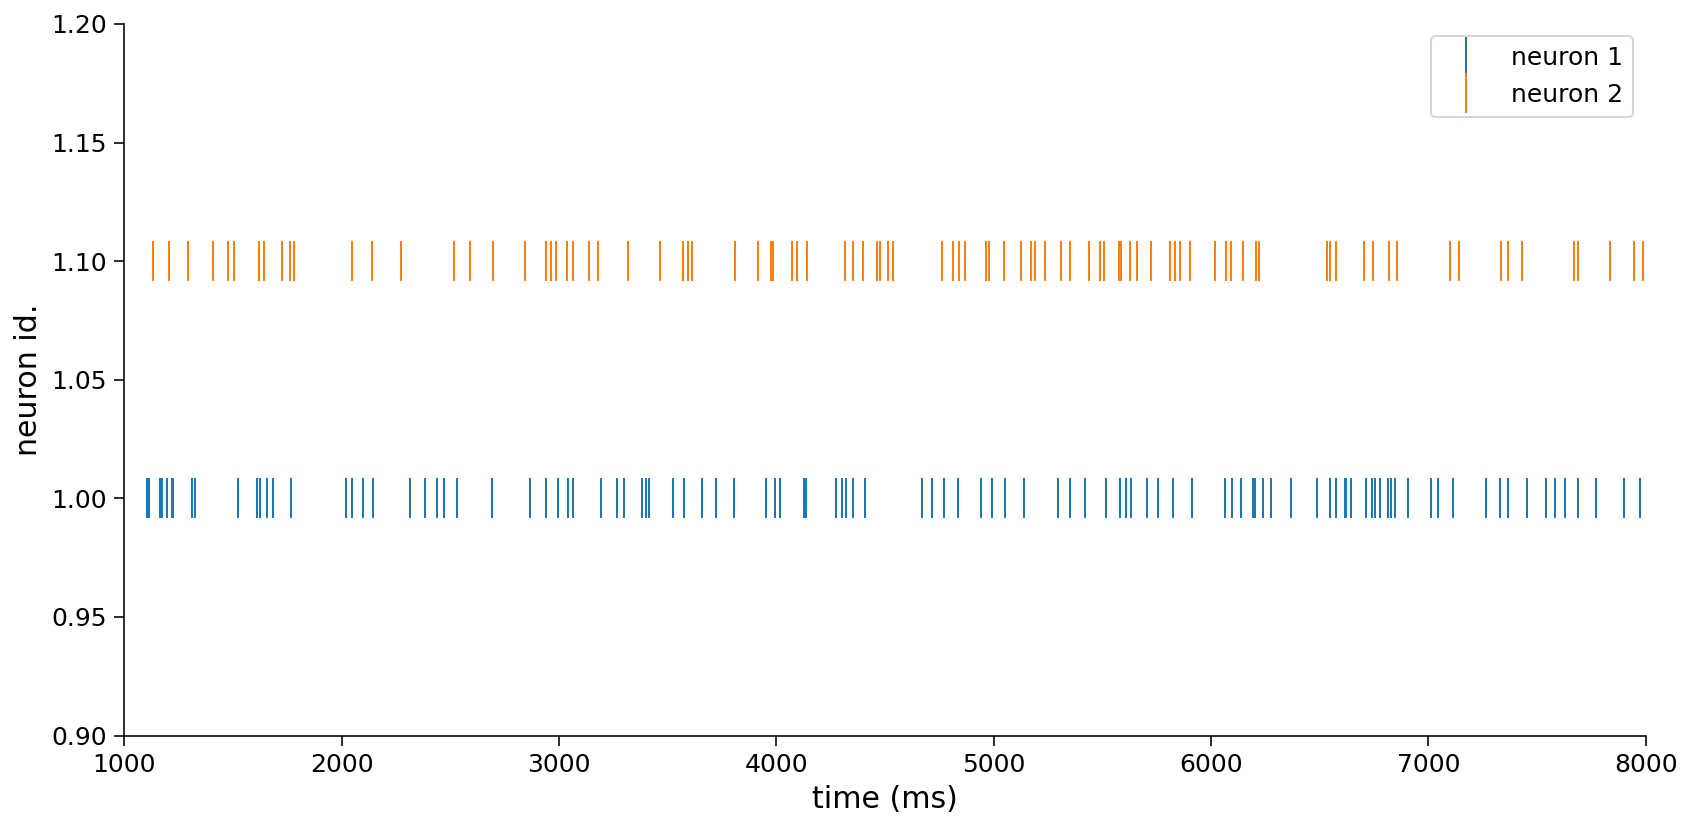

In [12]:
# @title

# @markdown Do not forget to execute this cell to simulate the LIF


bin_size = 10.  # ms

starttime = time.perf_counter()  # time clock

r12_ss, sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=gwn_mean, sig=gwn_std, c=c_in,
                                        bin_size=bin_size, n_trials=10)

# just the time counter
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

print(f"Input correlation = {c_in}")
print(f"Output correlation = {r12_ss}")

plt.figure(figsize=(12, 6))
plt.plot(sp1, np.ones(len(sp1)) * 1, '|', ms=20, label='neuron 1')
plt.plot(sp2, np.ones(len(sp2)) * 1.1, '|', ms=20, label='neuron 2')
plt.xlabel('time (ms)')
plt.ylabel('neuron id.')
plt.xlim(1000, 8000)
plt.ylim(0.9, 1.2)
plt.legend()
plt.show()

## Think!
- Is the output correlation always smaller than the input correlation? If yes, why?
- Should there be a systematic relationship between input and output correlations? 

You will explore these questions in the next figure but try to develop your own intuitions first!

Lets vary `c_in` and plot the relationship between the `c_in` and output correlation. This might take some time depending on the number of trials. 

Simulation time = 0.51 min


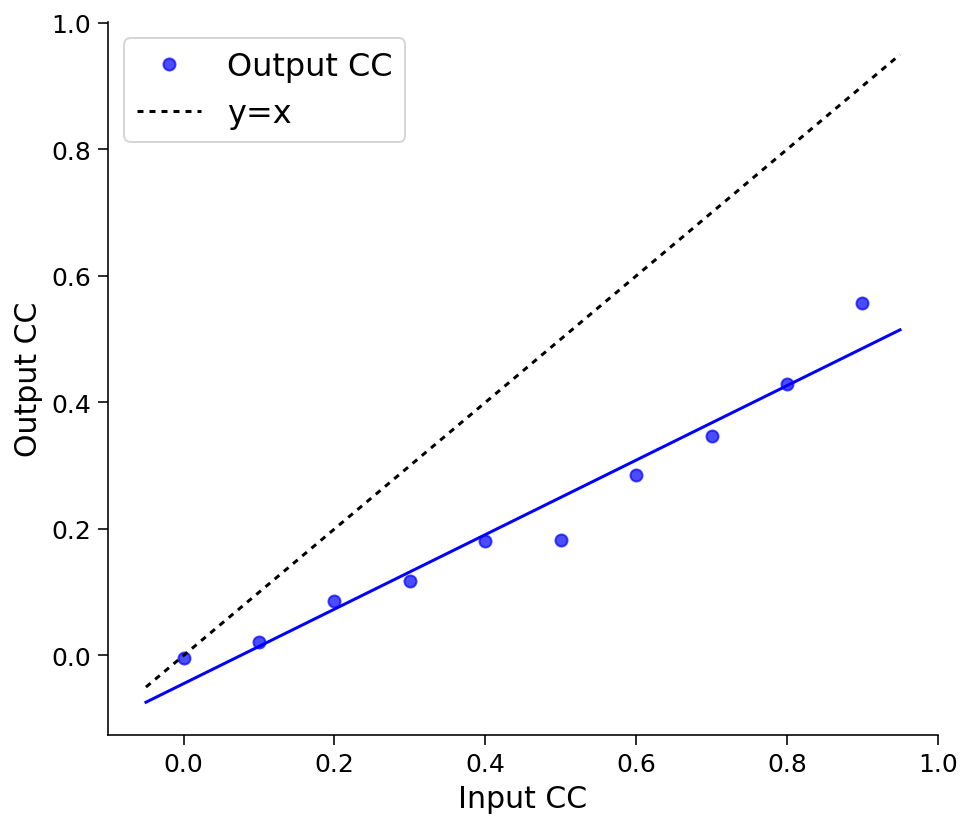

In [13]:
#@title

#@markdown Don't forget to execute this cell!

pars = default_pars(T=80000, dt=1.)  # get the parameters
bin_size = 10.
c_in = np.arange(0, 1.0, 0.1)  # set the range for input CC
r12_ss = np.zeros(len(c_in))  # small mu, small sigma

starttime = time.perf_counter() # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=10)

endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

plt.figure(figsize=(7, 6))
plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel='Output CC')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05], 
         [c_in.min() - 0.05, c_in.max() + 0.05], 
         'k--', dashes=(2, 2), label='y=x')

plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=16)
plt.show()

In [14]:
# to_remove explanation

"""
Discussion: The results above show that
- output correlation is smaller than input correlation
- output correlation varies linearly as a function of input correlation.

While the general result holds, this relationship might change depending on the neuron type. 
""";

---
# Section 3: Correlation transfer function
The above plot of input correlation vs. output correlation is called the __correlation transfer function__ of the neurons. 

## Section 3.1: How do the mean and standard deviation of the GWN affect the correlation transfer function?

The correlations transfer function appears to be linear. The above can be taken as the input/output transfer function of LIF neurons for correlations, instead of the transfer function for input/output firing rates as we had discussed in the previous tutorial (i.e., F-I curve).

What would you expect to happen to the slope of the correlation transfer function if you vary the mean and/or the standard deviation of the GWN?

Simulation time = 0.77 min


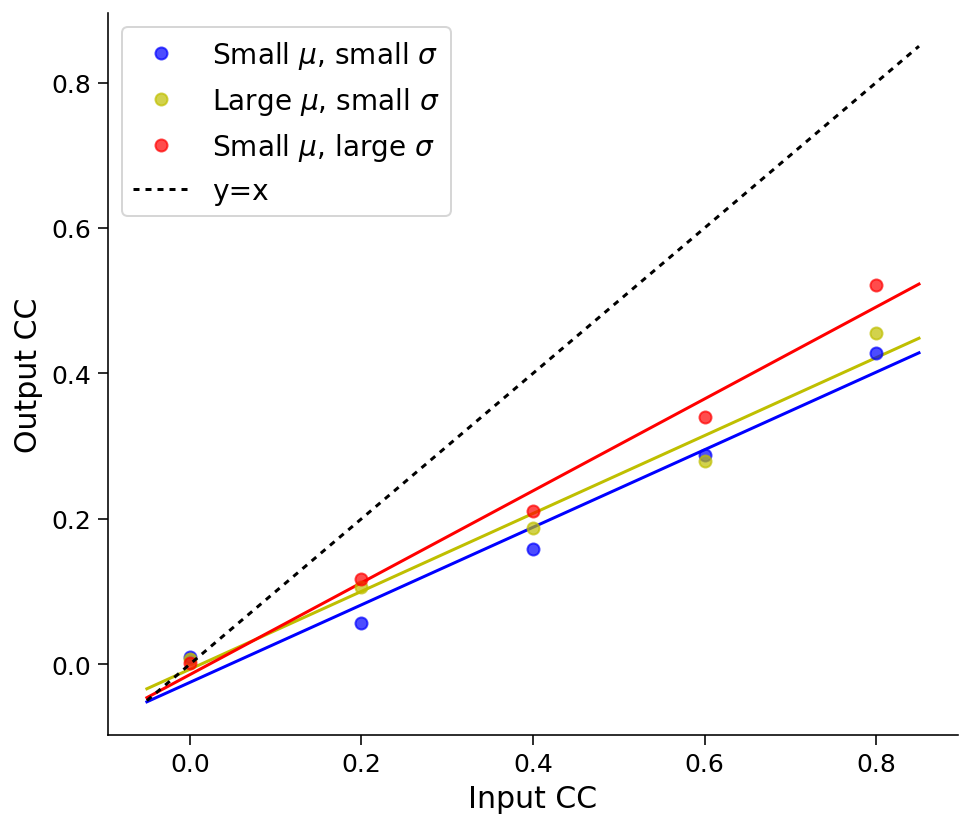

In [15]:
#@markdown Execute this cell to visualize correlation transfer functions

pars = default_pars(T=80000, dt=1.) # get the parameters
no_trial = 10
bin_size = 10.
c_in = np.arange(0., 1., 0.2)  # set the range for input CC
r12_ss = np.zeros(len(c_in))   # small mu, small sigma
r12_ls = np.zeros(len(c_in))   # large mu, small sigma
r12_sl = np.zeros(len(c_in))   # small mu, large sigma

starttime = time.perf_counter()  # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=no_trial)
  r12_ls[ic], sp_ls, sp1, sp2 = LIF_output_cc(pars, mu=18.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=no_trial)
  r12_sl[ic], sp_sl, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=20.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=no_trial)
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

plt.figure(figsize=(7, 6))
plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel=r'Small $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_ls, mycolor='y', mylabel=r'Large $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_sl, mycolor='r', mylabel=r'Small $\mu$, large $\sigma$')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05],
         [c_in.min() - 0.05, c_in.max() + 0.05],
         'k--', dashes=(2, 2), label='y=x')
plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=14)
plt.show()

### Think!
Why do both the mean and the standard deviation of the GWN affect the slope of the correlation transfer function? 

In [16]:
# to_remove explanation

"""
Discussion: This has got to do with which part of the input current distribution 
is transferred to the spiking activity.

Intuitive understanding is difficult but this relationship arises due to non-linearities 
in the neuron F-I curve.  When F-I curve is linear, output correlation is independent 
of the mean and standard deviation. But this relationship arises even in neurons with 
threshold-linear F-I curve.

Please see:
De La Rocha J, Doiron B, Shea-Brown E, Josić K, Reyes A. Correlation between 
neural spike trains increases with firing rate. Nature. 2007 Aug;448(7155):802-6. 
""";

## Section 3.2: What is the rationale behind varying $\mu$ and $\sigma$?
The mean and the variance of the synaptic current depends on the spike rate of a Poisson process. We can use [Campbell's theorem](https://en.wikipedia.org/wiki/Campbell%27s_theorem_(probability)) to estimate the mean and the variance of the synaptic current:

\begin{align}
\mu_{\rm syn} = \lambda J \int P(t) \\
\sigma_{\rm syn} = \lambda J \int P(t)^2 dt\\
\end{align}

where $\lambda$ is the firing rate of the Poisson input, $J$ the amplitude of the postsynaptic current and $P(t)$ is the shape of the postsynaptic current as a function of time. 

Therefore, when we varied $\mu$ and/or $\sigma$ of the GWN, we mimicked a change in the input firing rate. Note that, if we change the firing rate, both $\mu$ and $\sigma$ will change simultaneously, not independently. 

Here, since we observe an effect of $\mu$ and $\sigma$ on correlation transfer, this implies that the input rate has an impact on the correlation transfer function.


### Think!

- What are the factors that would make output correlations smaller than input correlations? (Notice that the colored lines are below the black dashed line)
- What does it mean for the correlation in the network?
- Here we have studied the transfer of correlations by injecting GWN. But in the previous tutorial, we mentioned that GWN is unphysiological. Indeed, neurons receive colored noise (i.e., Shot noise or OU process). How do these results obtained from injection of GWN apply to the case where correlated spiking inputs are injected in the two LIFs? Will the results be the same or different?

Reference
- De La Rocha, Jaime, et al. "Correlation between neural spike trains increases with firing rate." Nature (2007) (https://www.nature.com/articles/nature06028/)

- Bujan AF, Aertsen A, Kumar A. Role of input correlations in shaping the variability and noise correlations of evoked activity in the neocortex. Journal of Neuroscience. 2015 Jun 3;35(22):8611-25. (https://www.jneurosci.org/content/35/22/8611)

In [17]:
# to_remove explanation

"""
Discussion: 

1. Anything that tries to reduce the mean or variance of the input e.g. mean can 
be reduced by inhibition, sigma can be reduced by the membrane time constant. 
Obviously, if the two neurons have different parameters that will decorrelate them. 
But more importantly, it is the slope of neuron transfer function that will affect the 
output correlation.

2. These observations pose an interesting problem at the network level. If the 
output correlation are smaller than the input correlation, then the network activity 
should eventually converge to zero correlation. But that does not happen. So there 
is something missing in this model to understand origin of synchrony in the network.

3. For spike trains, if we do not have explicit control over mu and sigma. 
And these two variables will be tied to the firing rate of the inputs. So the 
results will be qualitatively similar. But when we think of multiple spike inputs 
two different types of correlations arise (see Bujan et al. 2015 for more info)
""";

---
# Summary

In this tutorial, we studied how the input correlation of two LIF neurons is mapped to their output correlation. Specifically, we:

- injected correlated GWN in a pair of neurons,

- measured correlations between the spiking activity of the two neurons, and

- studied how the transfer of correlation depends on the statistics of the input, i.e., mean and standard deviation.

Here, we were concerned with zero time lag correlation. For this reason, we restricted estimation of correlation to instantaneous correlations. If you are interested in time-lagged correlation, then we should estimate the cross-correlogram of the spike trains and find out the dominant peak and area under the peak to get an estimate of output correlations. 

We leave this as a future to-do for you if you are interested.

---
# Bonus 1: Example of a conductance-based LIF model
Above, we have written code to generate correlated Poisson spike trains. You can write code to stimulate the LIF neuron with such correlated spike trains and study the correlation transfer function for spiking input and compare it to the correlation transfer function obtained by injecting correlated GWNs.

In [18]:
# @title Function to simulate conductance-based LIF

def run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in):
  """
  conductance-based LIF dynamics

  Args:
    pars               : parameter dictionary
    I_inj              : injected current [pA]. The injected current here can
                         be a value or an array
    pre_spike_train_ex : spike train input from presynaptic excitatory neuron
    pre_spike_train_in : spike train input from presynaptic inhibitory neuron

  Returns:
    rec_spikes         : spike times
    rec_v              : mebrane potential
    gE                 : postsynaptic excitatory conductance
    gI                 : postsynaptic inhibitory conductance
  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  gE_bar, gI_bar = pars['gE_bar'], pars['gI_bar']
  VE, VI = pars['VE'], pars['VI']
  tau_syn_E, tau_syn_I = pars['tau_syn_E'], pars['tau_syn_I']
  tref = pars['tref']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  tr = 0.
  v = np.zeros(Lt)
  v[0] = V_init
  gE = np.zeros(Lt)
  gI = np.zeros(Lt)
  Iinj = I_inj * np.ones(Lt)  # ensure I has length Lt

  if pre_spike_train_ex.max() == 0:
    pre_spike_train_ex_total = np.zeros(Lt)
  else:
    pre_spike_train_ex_total = pre_spike_train_ex * np.ones(Lt)

  if pre_spike_train_in.max() == 0:
    pre_spike_train_in_total = np.zeros(Lt)
  else:
    pre_spike_train_in_total = pre_spike_train_in * np.ones(Lt)

  # simulation
  rec_spikes = []  # recording spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:   # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt
    # update the synaptic conductance
    gE[it+1] = gE[it] - (dt / tau_syn_E) * gE[it] + gE_bar * pre_spike_train_ex_total[it + 1]
    gI[it+1] = gI[it] - (dt / tau_syn_I) * gI[it] + gI_bar * pre_spike_train_in_total[it + 1]

    # calculate the increment of the membrane potential
    dv = (-(v[it] - E_L) - (gE[it + 1] / g_L) * (v[it] - VE) - \
            (gI[it + 1] / g_L) * (v[it] - VI) + Iinj[it] / g_L) * (dt / tau_m)

    # update membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes, gE, gI


print(help(run_LIF_cond))

Help on function run_LIF_cond in module __main__:

run_LIF_cond(pars, I_inj, pre_spike_train_ex, pre_spike_train_in)
    conductance-based LIF dynamics
    
    Args:
      pars               : parameter dictionary
      I_inj              : injected current [pA]. The injected current here can
                           be a value or an array
      pre_spike_train_ex : spike train input from presynaptic excitatory neuron
      pre_spike_train_in : spike train input from presynaptic inhibitory neuron
    
    Returns:
      rec_spikes         : spike times
      rec_v              : mebrane potential
      gE                 : postsynaptic excitatory conductance
      gI                 : postsynaptic inhibitory conductance

None


## Interactive Demo: Correlated spike input to an LIF neuron 

In the following you can explore what happens when the neurons receive correlated spiking input.

You can vary the correlation between excitatory input spike trains. For simplicity, the correlation between inhibitory spike trains is set to 0.01.

Vary both excitatory rate and correlation and see how the output correlation changes. Check if the results are qualitatively similar to what you observed previously when you varied the $\mu$ and $\sigma$.


Input correlation = 0.3
Output correlation = 0.5240669646233612


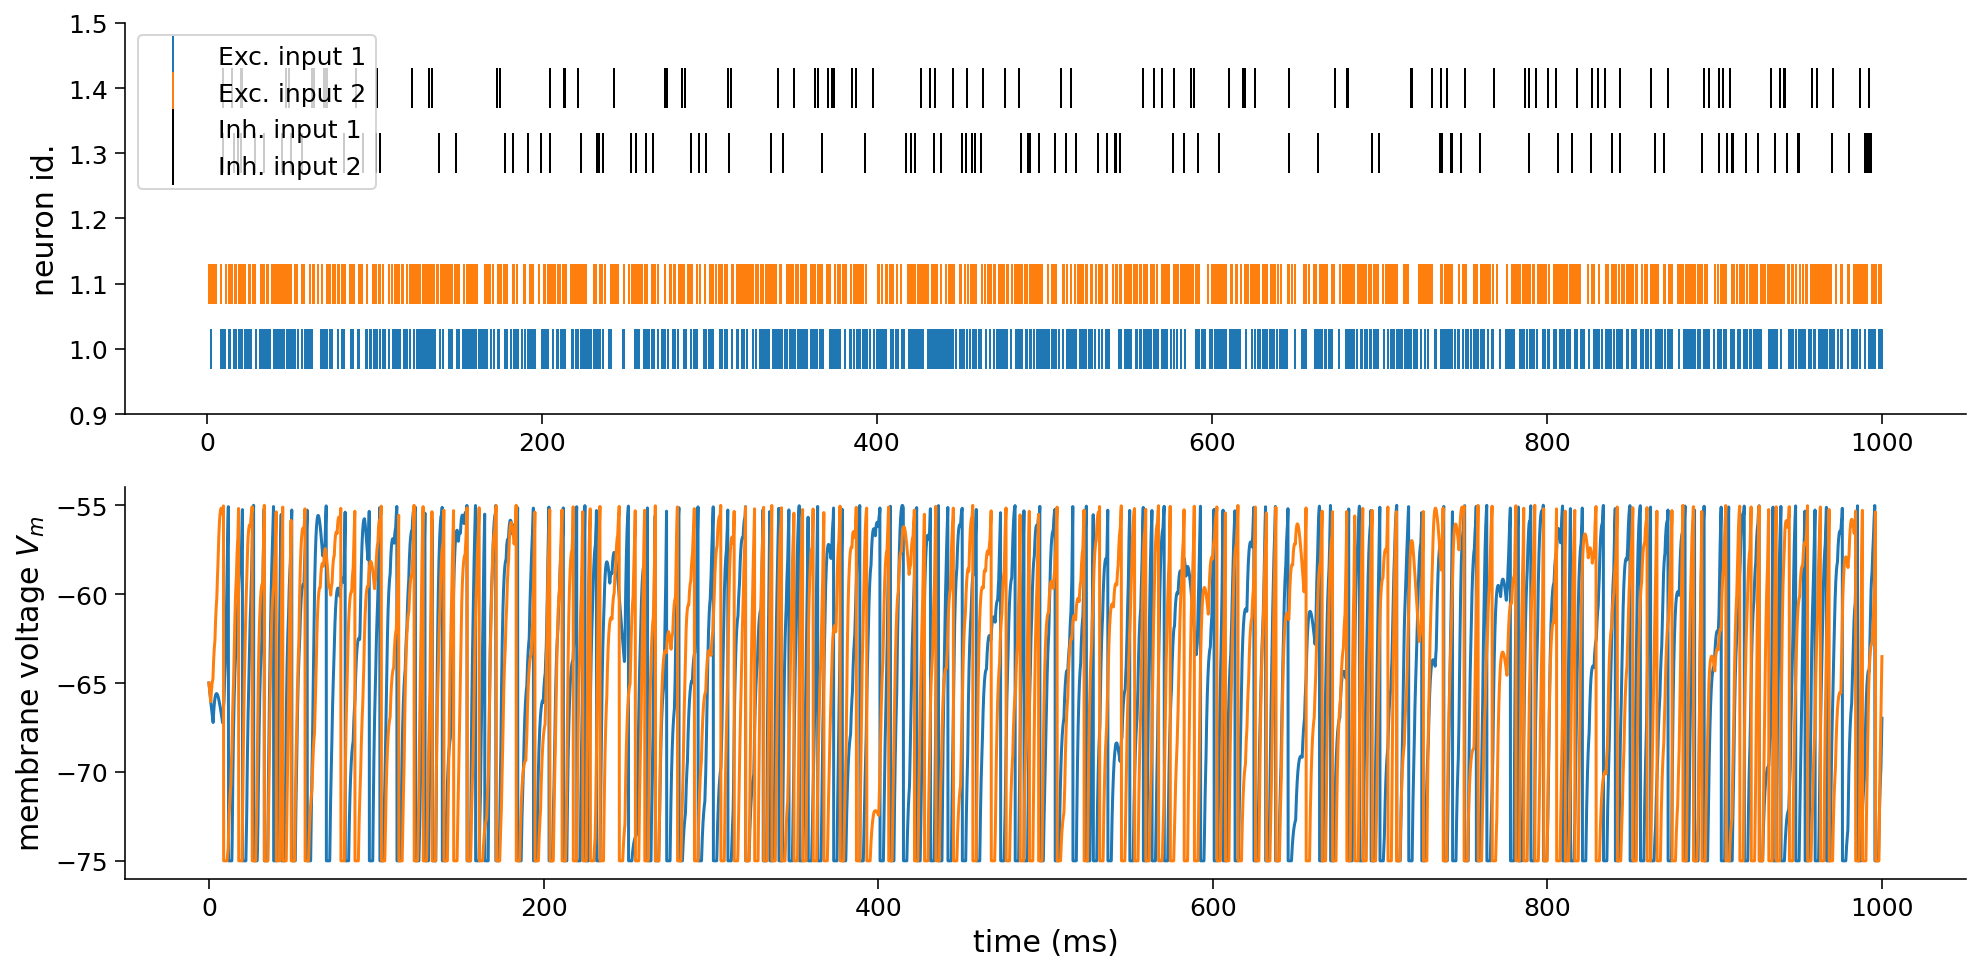

In [19]:
# @title

# @markdown Make sure you execute this cell to enable the widget!

my_layout.width = '450px'
@widgets.interact(
  pwc_ee=widgets.FloatSlider(0.3, min=0.05, max=0.99, step=0.01,
                             layout=my_layout),
  exc_rate=widgets.FloatSlider(1e3, min=500., max=5e3, step=50.,
                               layout=my_layout),
  inh_rate=widgets.FloatSlider(500., min=300., max=5e3, step=5.,
                               layout=my_layout),
)


def EI_isi_regularity(pwc_ee, exc_rate, inh_rate):
  pars = default_pars(T=1000.)
  # Add parameters
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -65.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  pars['gE_bar'] = 4.0    # [nS]
  pars['VE'] = 0.         # [mV] excitatory reversal potential
  pars['tau_syn_E'] = 2.  # [ms]
  pars['gI_bar'] = 2.4    # [nS]
  pars['VI'] = -80.       # [mV] inhibitory reversal potential
  pars['tau_syn_I'] = 5.  # [ms]

  my_bin = np.arange(0, pars['T']+pars['dt'], .1)  # 20 [ms] bin-size

  # exc_rate = 1e3
  # inh_rate = 0.4e3
  # pwc_ee = 0.3
  pwc_ii = 0.01
  # generate two correlated spike trains for excitatory input
  sp1e, sp2e = generate_corr_Poisson(pars, exc_rate, pwc_ee)

  sp1_spike_train_ex, _ = np.histogram(sp1e, bins=my_bin)
  sp2_spike_train_ex, _ = np.histogram(sp2e, bins=my_bin)

  # generate two uncorrelated spike trains for inhibitory input
  sp1i, sp2i = generate_corr_Poisson(pars, inh_rate, pwc_ii)
  sp1_spike_train_in, _ = np.histogram(sp1i, bins=my_bin)
  sp2_spike_train_in, _ = np.histogram(sp2i, bins=my_bin)

  v1, rec_spikes1, gE, gI = run_LIF_cond(pars, 0, sp1_spike_train_ex, sp1_spike_train_in)
  v2, rec_spikes2, gE, gI = run_LIF_cond(pars, 0, sp2_spike_train_ex, sp2_spike_train_in)

  # bin the spike time
  bin_size = 20  # [ms]
  my_bin = np.arange(0, pars['T'], bin_size)
  spk_1, _ = np.histogram(rec_spikes1, bins=my_bin)
  spk_2, _ = np.histogram(rec_spikes2, bins=my_bin)

  r12 = my_CC(spk_1, spk_2)
  print(f"Input correlation = {pwc_ee}")
  print(f"Output correlation = {r12}")

  plt.figure(figsize=(14, 7))
  plt.subplot(211)
  plt.plot(sp1e, np.ones(len(sp1e)) * 1, '|', ms=20,
           label='Exc. input 1')
  plt.plot(sp2e, np.ones(len(sp2e)) * 1.1, '|', ms=20,
           label='Exc. input 2')
  plt.plot(sp1i, np.ones(len(sp1i)) * 1.3, '|k', ms=20,
           label='Inh. input 1')
  plt.plot(sp2i, np.ones(len(sp2i)) * 1.4, '|k', ms=20,
           label='Inh. input 2')

  plt.ylim(0.9, 1.5)
  plt.legend()
  plt.ylabel('neuron id.')

  plt.subplot(212)
  plt.plot(pars['range_t'], v1, label='neuron 1')
  plt.plot(pars['range_t'], v2, label='neuron 2')
  plt.xlabel('time (ms)')
  plt.ylabel('membrane voltage $V_{m}$')
  plt.tight_layout()
  plt.show()


Above, we are estimating the output correlation for one trial. You can modify the code to get a trial average of output correlations.




---
# Bonus 2: Ensemble Response

Finally, there is a short BONUS lecture video on the firing response of an ensemble of neurons to time-varying input. There are no associated coding exercises - just enjoy.

Video available at https://youtube.com/watch?v=78_dWa4VOIo


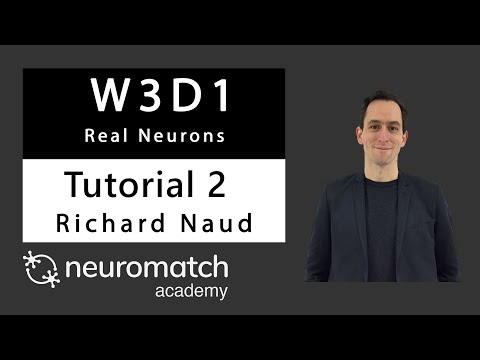

In [20]:
#@title Video 2 (Bonus): Response of ensemble of neurons to time-varying input
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="78_dWa4VOIo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video